In [1]:
import os
import sys
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.dirname(notebook_dir)

if project_dir not in sys.path:
    sys.path.append(project_dir)

import pandas as pd
import numpy as np

In [2]:
all_fighter_cluster = pd.read_csv(r"https://raw.githubusercontent.com/john-adeojo/ufc_styles/main/data/02_intermediate/all_fighter_clusters.csv")
fighter_data = pd.read_csv(r"https://github.com/john-adeojo/ufc_styles/blob/main/data/02_intermediate/fighter_data.csv?raw=true")
all_fighter_cluster = all_fighter_cluster.loc[all_fighter_cluster['cluster'] != -1]

In [3]:
analysis_data_base = fighter_data.merge(right=all_fighter_cluster[['cluster','specific_cluster', 'Fighter_dims', 'weight_class']], how='left', left_on=['Fighter_dims', 'weight_class'], right_on=['Fighter_dims', 'weight_class'])
analysis_data_base = analysis_data_base.dropna(subset=['cluster'])
analysis_data_opp = analysis_data_base.copy()
analysis_data_opp['opp_specific_cluster'] = analysis_data_opp['specific_cluster']
analysis_data = analysis_data_base.merge(right=analysis_data_opp[['weight_class', 'Fighter_dims', 'date', 'opp_specific_cluster']], how='inner', left_on=['weight_class', 'Opponent', 'date'], right_on=['weight_class', 'Fighter_dims', 'date'] )
analysis_data_opposing_styles = analysis_data.loc[analysis_data['opp_specific_cluster'] != analysis_data['specific_cluster']].copy()

In [4]:
analysis_data_opposing_styles = analysis_data_opposing_styles.loc[analysis_data_opposing_styles['corner'] == 'Red'].copy()
analysis_data_opposing_styles = analysis_data_opposing_styles.loc[analysis_data_opposing_styles['fighter_result'] != 'Loss by DQ'].copy()

In [5]:
import pandas as pd

# Assuming your DataFrame is named 'analysis_data_opposing_styles'
# and the columns to combine are 'specific_cluster' and 'opp_specific_cluster'

def create_style_matchup(row):
    # Combine the two columns and sort them alphabetically
    matchup = sorted([row['specific_cluster'], row['opp_specific_cluster']])
    
    # Join them with ' vs. ' and return the result
    return matchup[0] + ' vs. ' + matchup[1]

# Apply the custom function to each row and create the new 'style_matchup' column
analysis_data_opposing_styles['style_matchup'] = analysis_data_opposing_styles.apply(create_style_matchup, axis=1)

# Display the DataFrame
analysis_data_opposing_styles.sort_values(by='weight_class', inplace=True)


In [6]:
weight_class = list(analysis_data_opposing_styles['weight_class'].drop_duplicates())
weight_class

['Bantamweight',
 'Featherweight',
 'Heavyweight',
 'LightHeavyweight',
 'Lightweight',
 'Middleweight',
 'Welterweight']

In [7]:
from scripts.chisquareanalysis import ChiSquareAnalysis

# Assuming weight_class is a list of weight classes

results = {}  # Initialize an empty dictionary to store the results

for weights in weight_class:
    analysis = ChiSquareAnalysis(df=analysis_data_opposing_styles, weight_class=weights)
    result, significant_weight_class = analysis.run_chisquare_analysis('fighter_result')
    if not isinstance(result, str):
        results[significant_weight_class] = result  # Save the result in the dictionary with the key as the weight class
    

Bantamweight
Chi2 Stat: 96.93363950201454
P Value: 1.296818633731241e-13
Degrees of Freedom: 16
Featherweight
Chi2 Stat: 0.0
P Value: 1.0
Degrees of Freedom: 0
Heavyweight
Chi2 Stat: 0.0
P Value: 1.0
Degrees of Freedom: 0
LightHeavyweight
Chi2 Stat: 1756.7582602391035
P Value: 1.0196458746493108e-269
Degrees of Freedom: 154
Lightweight
Chi2 Stat: 2340.213845351824
P Value: 0.0
Degrees of Freedom: 200
Middleweight
Chi2 Stat: 0.0
P Value: 1.0
Degrees of Freedom: 0
Welterweight
Chi2 Stat: 3466.5881482545583
P Value: 0.0
Degrees of Freedom: 385


In [8]:
significant_weight_classes = list(results.keys())
significant_weight_classes

['Bantamweight', 'LightHeavyweight', 'Lightweight', 'Welterweight']

In [9]:
fighter_result = list(analysis_data_opposing_styles['fighter_result'].drop_duplicates())

In [10]:
standard_residuals = {}  # Initialize an empty dictionary to store the results

for weights in significant_weight_classes:
    standard_residuals[weights] = results[weights]  # Save the result in the dictionary with the key as the weight class


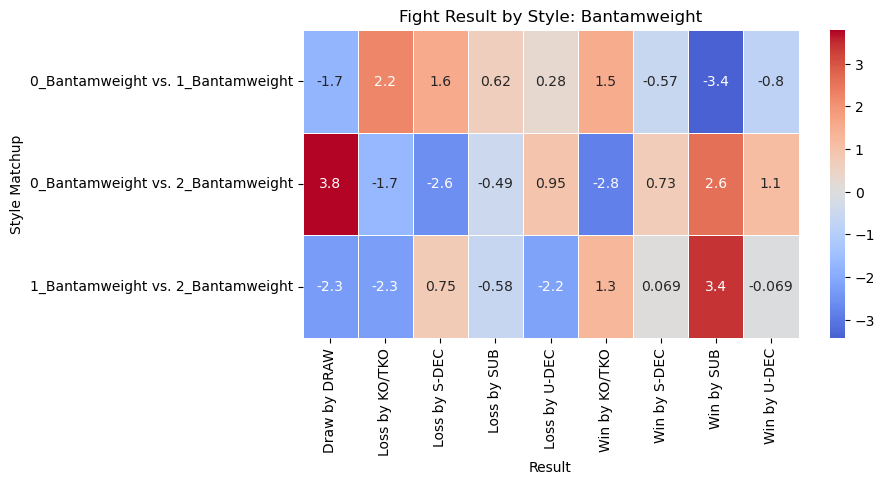

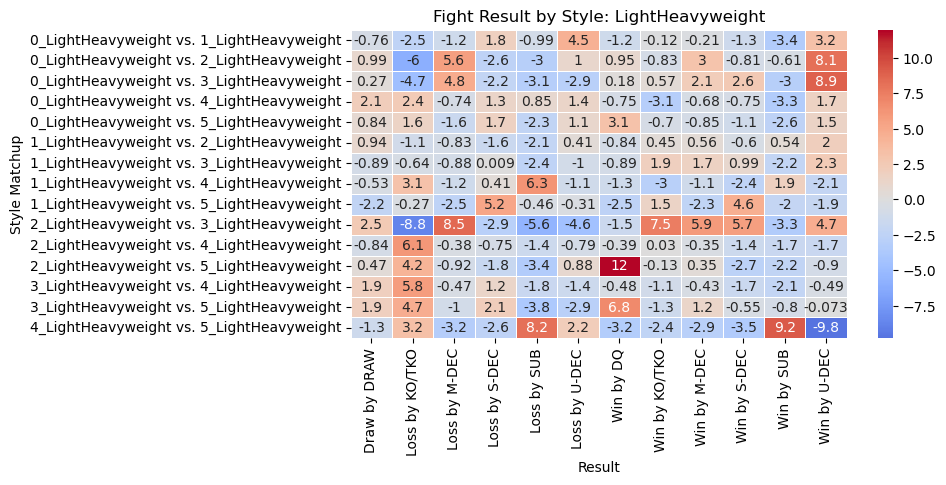

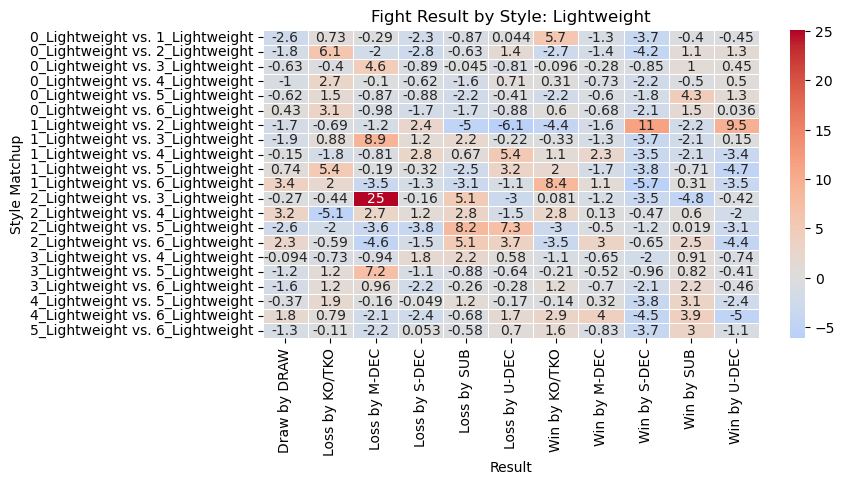

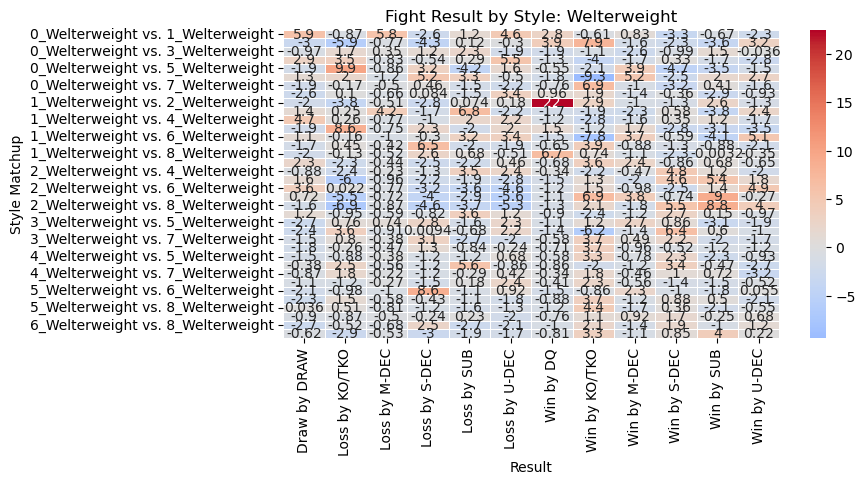

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(standard_residuals, weight_class):
    col = standard_residuals.drop(columns=['style_matchup']).columns
    # Prepare the data for the heatmap
    heatmap_data = standard_residuals.set_index('style_matchup')[col]
    # Create the heatmap
    plt.figure(figsize=(8, 4))
    sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, linewidths=0.5, center=0)
    plt.title(f'Fight Result by Style: {weight_class}')
    plt.xlabel('Result')
    plt.ylabel('Style Matchup')
    #plt.savefig(r"C:\Users\johna\anaconda3\envs\twitter-influence-env\twitter-influence\data\03_reports\sentiment_heatmap.png")
    plt.show()

    
for weights in significant_weight_classes:
    heatmap(standard_residuals=standard_residuals[weights], weight_class=weights)


In [12]:
import requests
import json
# import style dims
url = 'https://github.com/john-adeojo/ufc_styles/raw/main/data/02_intermediate/style_dims_names.json'

# Fetch the JSON file content
response = requests.get(url)

# Check if the request was successful (HTTP status code 200)
if response.status_code == 200:
    try:
        # Load the content into a list
        style_dims_names = json.loads(response.text)
        print("Data loaded successfully:")
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON: {e}")
else:
    print(f"Failed to fetch JSON file: {response.status_code}")

Data loaded successfully:


In [13]:
style_dims_names_2 = style_dims_names
style_dims_names_2.append('specific_cluster')

In [14]:
def generate_radar_data(selected_clusters):
    selected_clusters = selected_clusters
    filtered_data = all_fighter_cluster[all_fighter_cluster['specific_cluster'].isin(selected_clusters)]
    analytics_for_radar = filtered_data[style_dims_names_2].groupby(['specific_cluster']).mean()
    analytics_for_radar.reset_index(inplace=True)
    return analytics_for_radar

radar_chart_data = {}
for weights in significant_weight_classes:
    selected_clusters = list(all_fighter_cluster.loc[all_fighter_cluster['weight_class'] == weights]['specific_cluster'].drop_duplicates())
    radar_chart_data[weights] = generate_radar_data(selected_clusters)
    

radar_chart_data['Bantamweight']

specific_cluster    avg_KD  avg_opp_KD  avg_SUB_ATT  avg_opp_SUB_ATT  \
0   0_Bantamweight -0.035756   -0.012743    -0.157396        -0.071067   
1   1_Bantamweight -0.030892   -0.075227     0.185382         0.249294   
2   2_Bantamweight -0.059316   -0.086429     0.228371         0.870612   

    avg_REV  avg_opp_REV  avg_SIG_STR_att  avg_SIG_STR_landed  \
0  0.042543     0.086539         0.304802            0.215519   
1  0.224052     0.198504         0.041838           -0.082768   
2  0.233199     0.208529        -0.143744           -0.179377   

   avg_opp_SIG_STR_att  ...  avg_GROUND_landed  avg_opp_GROUND_att  \
0             0.287538  ...          -0.070066           -0.133151   
1             0.043163  ...           0.031040           -0.086069   
2            -0.365857  ...           0.055944           -0.195061   

   avg_opp_GROUND_landed  avg_CTRL_time(seconds)  avg_opp_CTRL_time(seconds)  \
0              -0.111354               -0.268694                   -0.178472   
1              -0.108830               -0.003649                    0.009350   
2              -0.237468                0.384439                   -0.163236   

   Stance_Open Stance  Stance_Orthodox  Stance_Sideways  Stance_Southpaw  \
0                 0.0         0.720000              0.0         0.128571   
1                 0.0         0.876190              0.0         0.123810   
2                 0.0         0.818182              0.0         0.181818   

   Stance_Switch  
0       0.151429  
1       0.000000  
2       0.000000  

[3 rows x 50 columns]

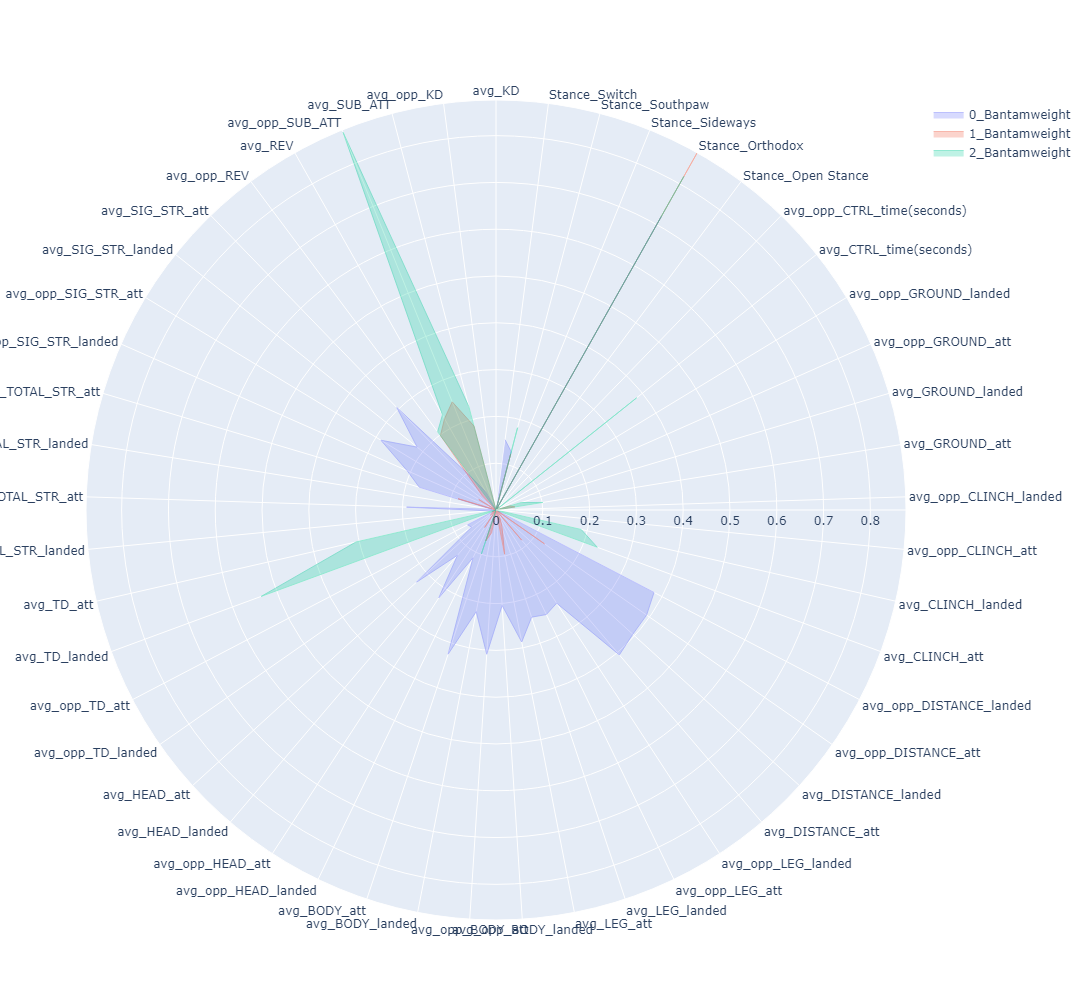

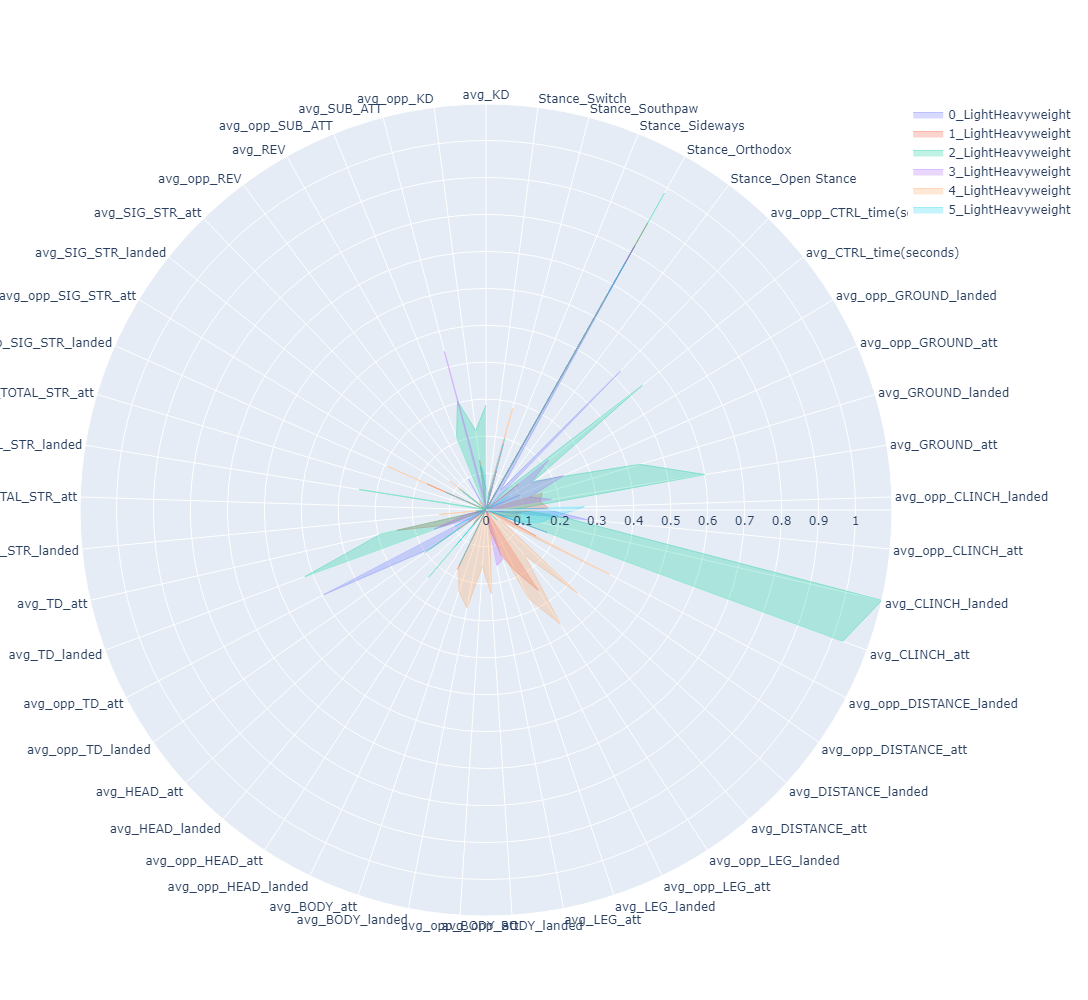

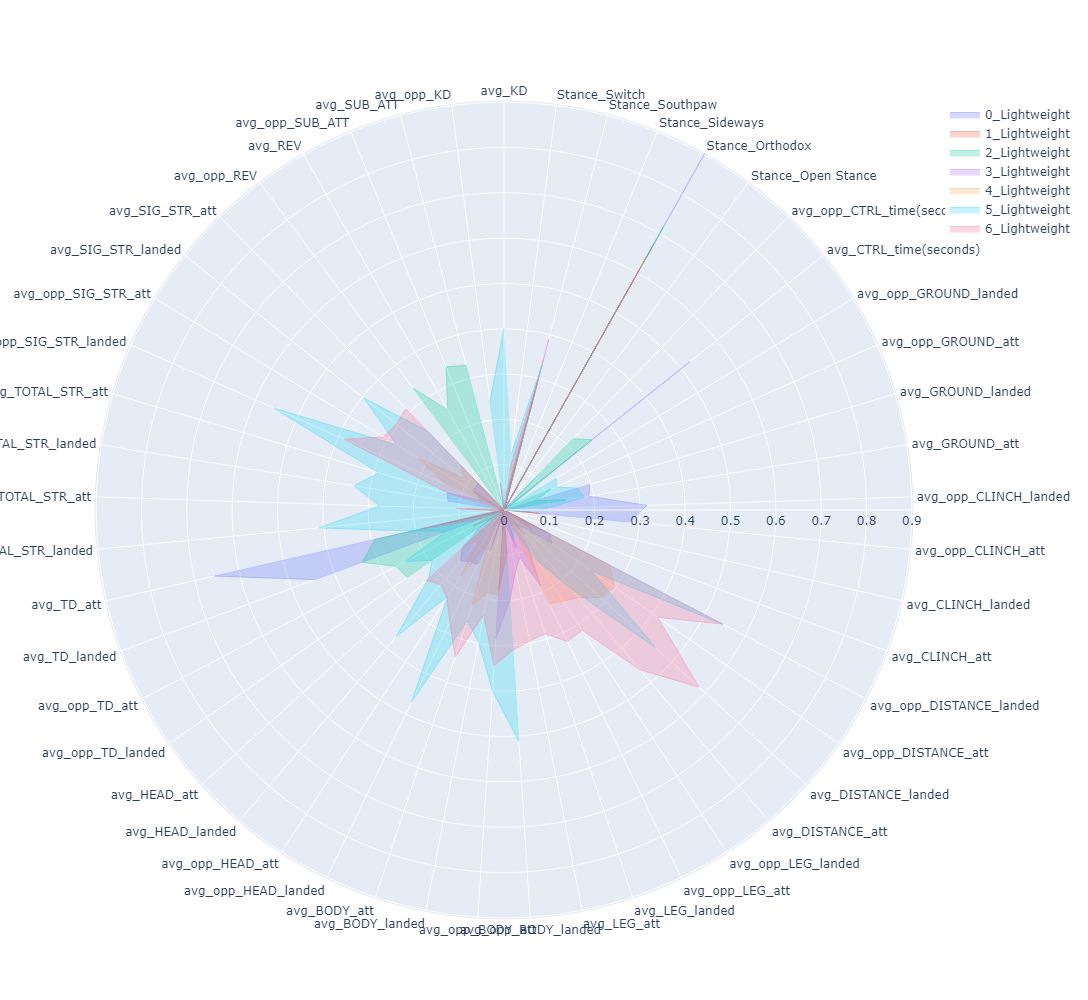

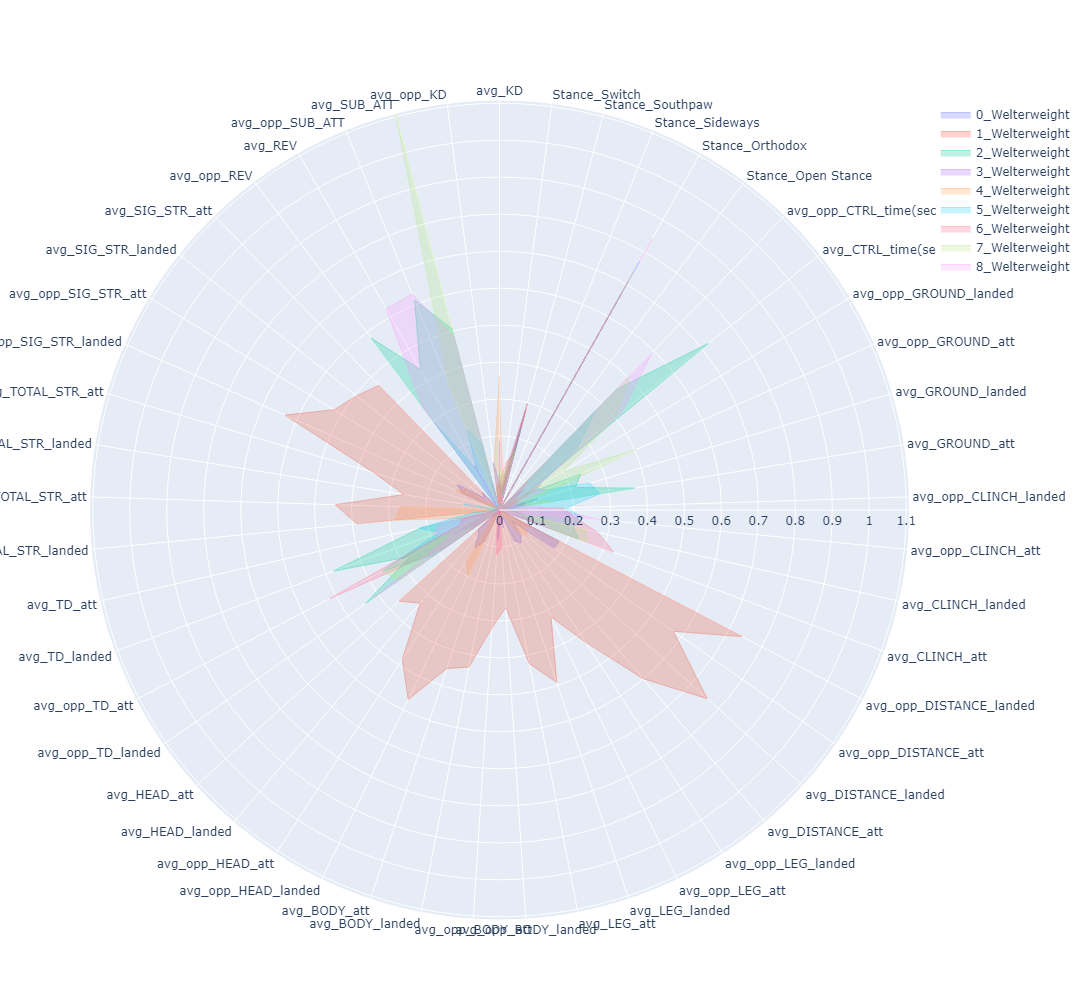

In [15]:
import plotly.graph_objects as go
import pandas as pd

# Replace this with your actual dataframe
# analytics_for_radar = ...

# Select dimensions to plot
#selected_dimensions = analytics_for_radar.drop(columns='specific_cluster').columns

def plot_fighters_radar_chart(data, weight_class):
    
    dimensions = data.drop(columns='specific_cluster').columns
    fig = go.Figure()
    

    for specific_cluster in data['specific_cluster'].unique():
        cluster_data = data[data['specific_cluster'] == specific_cluster]

        fig.add_trace(go.Scatterpolar(
            r=cluster_data[dimensions].values.tolist()[0],
            theta=dimensions,
            fill='toself',
            name=specific_cluster,
            opacity=0.5,
            line=dict(width=0.8)
        ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, data[dimensions].values.astype(float).max()]  # Set the range based on the maximum value in the data
            ),
            angularaxis=dict(
                rotation=90,
                direction="counterclockwise"
            ),
        ),
        showlegend=True,
        width=1400,
        height=1000
    )
    
    #plot_fighters_radar_chart(save_path=f"C:\\Users\\johna\\anaconda3\\envs\\ufc-env\\ufc_styles\\data\\03_reports\\radar_plots_{weight_class}.png")

    fig.show()

for weights in significant_weight_classes:
    plot_fighters_radar_chart(data=radar_chart_data[weights], weight_class=weight_class)
